# PREVISÃO DA VELOCIDADE DO VENTO A CURTO PRAZO USANDO REDES NEURAIS ARTIFICIAIS EM MUCURI, BAHIA

## Configuração

Realizando imports necessários.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from IPython.display import SVG
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import model_to_dot
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Incluindo função que calcula o Coeficiente de correlação de `Pearson` `r`.

In [2]:
def r2_loss(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

Definição do modelo. 

In [3]:
class MucuriModel:
    def __init__(self):

        self.model = None
        self._build_model()

    def _build_model(self):

        if self.model is None:
            self.model = Sequential()
            self.model.add(Dense(9, input_shape=(9,)))
            self.model.add(Dense(9, activation="tanh"))
            self.model.add(Dense(6, activation="tanh"))
            self.model.add(Dense(1, activation="linear"))
            self.model.compile(
                loss="mean_squared_error",
                optimizer=Adam(lr=0.01),
                metrics=["mse", "mae", r2_loss],
            )

    def train(self, X, Y, X_test=None, Y_test=None):

        assert self.model is not None

        checkpoint = ModelCheckpoint(
            filepath="./weights.hdf5", save_best_only=True, monitor="mse"
        )
        return self.model.fit(
            X,
            Y,
            validation_data=(X_test, Y_test)
            if X_test is not None and Y_test is not None
            else None,
            verbose=0,
            epochs=600,
            callbacks=[checkpoint],
        )

    def predict(self, data):

        assert self.model is not None

        return self.model.predict(data)

Foi utilizada a configuração 5 para a construção desse modelo, conforme especificado no paper. A quantidade de épocas foi definida como 600, a função de loss foi definida como a de `mean squared error` e as métricas MSE, MAE e r2 são usadas para a avaliação da performance. O otimizador Adam foi utilizado, configurado com o `learning rate` de 0.01.

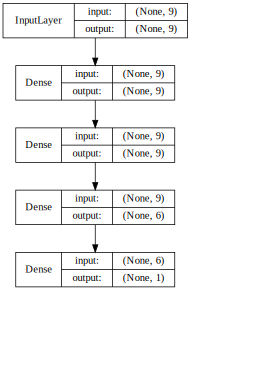

In [4]:
model = MucuriModel()
SVG(model_to_dot(model.model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

## Leitura e normalização dos dados

Lendo o arquivo que contém os dados a serem analisados.

In [5]:
_file = pd.ExcelFile("./Mucuri_novo_semNaN_torre150m.xlsx")

df = _file.parse("Dados anemo")

Carregando os dados de treino e teste, ordenando as colunas da seguinte maneira:

> pressão, umid, temp, dir_1, v_anemo2, hora, ano, mês, dia

As informações referentes às datas (i.e. ano, mês e dia) foram colocadas por último, já que a sua repetição na massa de dados dificulta a convergência do modelo.

In [6]:
train_data_1 = df[pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=22)]
train_data_2 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] <= 11)
]

X_train = pd.concat([train_data_1, train_data_2]).drop("Data", axis=1)

Y_train = X_train.v_anemo2.shift(-1)
Y_train.drop(Y_train.tail(1).index, inplace=True)

X_train.drop(X_train.tail(1).index, inplace=True)

cols = X_train.columns.tolist()
cols = cols[::-1]

X_train = X_train[cols]

In [7]:
test_data_1 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] >= 12)
]
test_data_2 = df[
    (pd.to_datetime(df["Data"]) >= datetime(year=2015, month=12, day=24))
    & (pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=30))
]
test_data_3 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=31))
    & (df["hora"] <= 13)
]

X_test = pd.concat([test_data_1, test_data_2, test_data_3]).drop("Data", axis=1)

Y_test = X_test.v_anemo2.shift(-1)
Y_test.drop(Y_test.tail(1).index, inplace=True)

X_test.drop(X_test.tail(1).index, inplace=True)

cols = X_train.columns.tolist()
cols = cols[::-1]

X_test = X_test[cols]

Realizando a normalização com `minmax`.

In [8]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train.values)
X_test = scaler.fit_transform(X_test.values)

## Treino

Realizando o processo de treino do modelo, incluindo dados de validação.

In [9]:
training_history = model.train(X_train, Y_train.values, X_test, Y_test.values)

## Avaliação

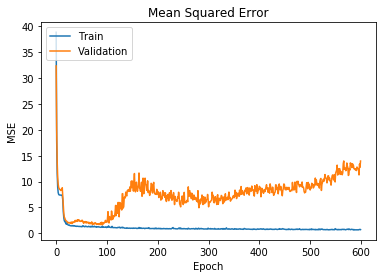

In [10]:
plt.plot(training_history.history["mse"])
plt.plot(training_history.history["val_mse"])
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show();

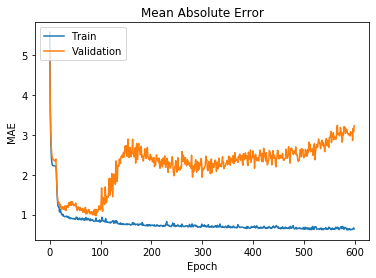

In [11]:
plt.plot(training_history.history["mae"])
plt.plot(training_history.history["val_mae"])
plt.title("Mean Absolute Error")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show();

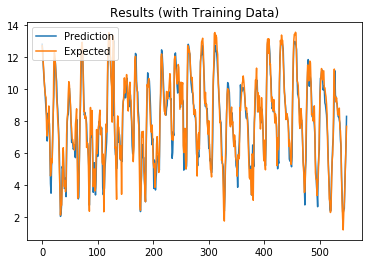

In [12]:
predictions = [model.predict([[value]])[0][0] for value in X_train]
    
plt.plot(predictions)
plt.plot(Y_train.values)
plt.title("Results (with Training Data)")
plt.legend(["Prediction", "Expected"], loc="upper left")
plt.show();


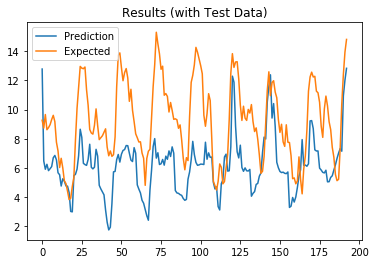

In [13]:
predictions = [model.predict([[value]])[0][0] for value in X_test]
    
plt.plot(predictions)
plt.plot(Y_test.values)
plt.title("Results (with Test Data)")
plt.legend(["Prediction", "Expected"], loc="upper left")
plt.show();
